In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import general_functions

In [19]:
def sim_alpha(N: int, steps: int, alpha: float) -> tuple:
    """Two company transactions.

    Args:
        steps (int): System iterations
        alpha (float): Money to production efficiency parameter

    Returns:
        tuple: history of p and m values for both companies
    """
    # Initial m and p values and history arrays
    p = np.ones(N)
    m = np.ones(N)
    p_hist = np.empty((N, steps))
    m_hist = np.empty((N, steps))
    p_hist[:, 0] = p
    m_hist[:, 0] = m

    for i in range(1, steps):
        # Choose seller and buyer
        buyer = np.random.randint(low=0, high=N)
        available_seller = np.arange(0, N)[np.arange(0, N) != buyer]
        seller = np.random.choice(a=available_seller)
        
        # Make transaction
        delta_m = np.min(np.array([p[seller], m[buyer]]))
        m[seller] += delta_m
        m[buyer] -= delta_m
        p[buyer] += alpha * delta_m 
        
        # Update history
        p_hist[:, i] = p * 1
        m_hist[:, i] = m * 1
        
    # Calculate mean values
    p_mean = np.mean(a=p_hist, axis=0)
    m_mean = np.mean(a=m_hist, axis=0)
    
    return p_mean, m_mean


def sim_alpha_delta(N, steps, alpha, delta):
    """Two company transactions.

    Args:
        steps (int): System iterations
        alpha (float): Money to production efficiency parameter

    Returns:
        tuple: history of p and m values for both companies
    """
    # Initial m and p values and history arrays
    p = np.ones(N)
    m = np.ones(N)
    p_hist = np.empty((N, steps))
    m_hist = np.empty((N, steps))
    p_hist[:, 0] = p
    m_hist[:, 0] = m

    for i in range(1, steps):
        # Choose seller and buyer
        buyer = np.random.randint(low=0, high=N)
        available_seller = np.arange(0, N)[np.arange(0, N) != buyer]
        seller = np.random.choice(a=available_seller)
        
        # Make transaction
        delta_m = np.min(np.array([p[seller], m[buyer]]))
        m[seller] += delta_m
        m[buyer] -= delta_m
        p[buyer] += alpha * delta_m 
        p[seller] -= delta * delta_m
        
        # Update history
        p_hist[:, i] = p * 1
        m_hist[:, i] = m * 1
    
    # Calculate mean values
    p_mean = np.mean(a=p_hist, axis=0)
    m_mean = np.mean(a=m_hist, axis=0)
    
    return p_mean, m_mean


def alpha_mean_of_means(repeats, N, steps, alpha):
    p_means_list = np.empty((steps, repeats))
    m_means_list = np.empty((steps, repeats))
    
    # Simulate repeats times
    for i in range(repeats):
        p_mean, m_mean = sim_alpha(N, steps, alpha)
        p_means_list[:, i] = p_mean
        m_means_list[:, i] = m_mean
    
    # Calculate mean of means
    p_means = np.mean(p_means_list, axis=1)
    m_means = np.mean(m_means_list, axis=1)
    p_std = np.std(p_means_list, axis=1)
    m_std = np.std(m_means_list, axis=1)
    
    return p_means, m_means, p_std, m_std


def alpha_delta_mean_of_means(repeats, N, steps, alpha, delta):
    p_means_list = np.empty((steps, repeats))
    m_means_list = np.empty((steps, repeats))
    
    # Simulate repeats times
    for i in range(repeats):
        p_mean, m_mean = sim_alpha_delta(N, steps, alpha, delta)
        p_means_list[:, i] = p_mean
        m_means_list[:, i] = m_mean
    
    # Calculate mean of means
    p_means = np.mean(p_means_list, axis=1)
    m_means = np.mean(m_means_list, axis=1)
    p_std = np.std(p_means_list, axis=1)
    m_std = np.std(m_means_list, axis=1)
    
    return p_means, m_means, p_std, m_std

In [20]:
def linear(x, a, b):
    return a * x + b


def plot(repeats, N, steps, alpha_a, alpha_ad, delta):
    # Get data
    p_a, m_a, p_std_a, m_std_a = alpha_mean_of_means(repeats, N, steps, alpha_a)
    p_ad, m_ad, p_std_ad, m_std_ad = alpha_delta_mean_of_means(repeats, N, steps, alpha_ad, delta)
    time = np.arange(steps)
    
    # Only include every 10'th point
    p_a = p_a[::10]
    p_ad = p_ad[::10]
    p_std_a = p_std_a[::10]
    p_std_ad = p_std_ad[::10]
    
    # Calculate linear data
    offset_a = p_a[0]
    offset_ad = p_ad[0]
    slope_a = alpha_a / N -  offset_a / steps
    slope_ad = (alpha_ad - delta) / N - offset_ad / steps
    
    linear_a = linear(time, slope_a, b=offset_a)
    linear_ad = linear(time, slope_ad, b=offset_ad)
    
    # Create figure
    fig, (ax, ax1) = plt.subplots(nrows=2)
    
    # Alpha sim
    ax.errorbar(time, p_a, yerr=p_std_a)
    # ax.errorbar(time, m_a, yerr=m_std_a, c="black")
    ax.plot(time, linear_a, ls="dashed")
    
    # Alpha-delta sim
    ax1.errorbar(time, p_ad, yerr=p_std_ad)
    # ax1.errorbar(time, m_ad, yerr=m_std_ad, c="black")
    ax1.plot(time, linear_ad, ls="dashed")
    
    # Axis setup
    ax.set(ylabel="$", title=fr"$\alpha = {alpha_a}$")
    ax1.set(ylabel="$", xlabel="Time steps", title=fr"$\alpha = {alpha_ad}, \delta = {delta}$")
    
    # Grids
    ax.grid()
    ax1.grid()
    
    # Legend
    legend_elements = [Line2D([], [], color="rebeccapurple", label="Production"),
                        Line2D([], [], color="black", label="Money"),
                        Line2D([], [], color="firebrick", label="y=ax + b", linestyle="dashed")]
    fig.subplots_adjust(hspace=0.55)
    fig.legend(handles=legend_elements, ncols=3, bbox_to_anchor=(0.5, 0.45), loc="lower center")
    
    fig.suptitle(r"$\alpha$ vs $\alpha - \delta$")
    plt.show()

In [21]:
def linear(x, a, b):
    return a * x + b


def plot(repeats, N, steps, alpha_a, alpha_ad, delta):
    # Get data
    p_a, m_a, p_std_a, m_std_a = alpha_mean_of_means(repeats, N, steps, alpha_a)
    p_ad, m_ad, p_std_ad, m_std_ad = alpha_delta_mean_of_means(repeats, N, steps, alpha_ad, delta)
    time = np.arange(steps)
    
    # Only include every 10'th point
    p_a = p_a[::10]
    p_ad = p_ad[::10]
    p_std_a = p_std_a[::10]
    p_std_ad = p_std_ad[::10]
    time = time[::10]
    
    
    # Calculate linear data
    offset_a = p_a[0]
    offset_ad = p_ad[0]
    slope_a = alpha_a / N -  offset_a / steps
    slope_ad = (alpha_ad - delta) / N - offset_ad / steps
    
    linear_a = linear(time, slope_a, b=offset_a)
    linear_ad = linear(time, slope_ad, b=offset_ad)
    
    # Create figure
    fig, (ax, ax1) = plt.subplots(nrows=2)
    
    # Alpha sim
    ax.errorbar(time, p_a, yerr=p_std_a)
    # ax.errorbar(time, m_a, yerr=m_std_a, c="black")
    ax.plot(time, linear_a, ls="dashed")
    
    # Alpha-delta sim
    ax1.errorbar(time, p_ad, yerr=p_std_ad)
    # ax1.errorbar(time, m_ad, yerr=m_std_ad, c="black")
    ax1.plot(time, linear_ad, ls="dashed")
    
    # Axis setup
    ax.set(ylabel="$", title=fr"$\alpha = {alpha_a}$")
    ax1.set(ylabel="$", xlabel="Time steps", title=fr"$\alpha = {alpha_ad}, \delta = {delta}$")
    
    # Grids
    ax.grid()
    ax1.grid()
    
    # Legend
    legend_elements = [Line2D([], [], color="rebeccapurple", label="Production"),
                        # Line2D([], [], color="black", label="Money"),
                        Line2D([], [], color="firebrick", label="y=ax + b", linestyle="dashed")]
    fig.subplots_adjust(hspace=0.55)
    fig.legend(handles=legend_elements, ncols=3, bbox_to_anchor=(0.2, 0.85), loc="lower center")
    
    fig.suptitle(r"$\alpha$ vs $\alpha - \delta$")
    plt.show()

C:\Users\tobia\AppData\Local\Temp\ipykernel_8816\709981730.py:53: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.55)


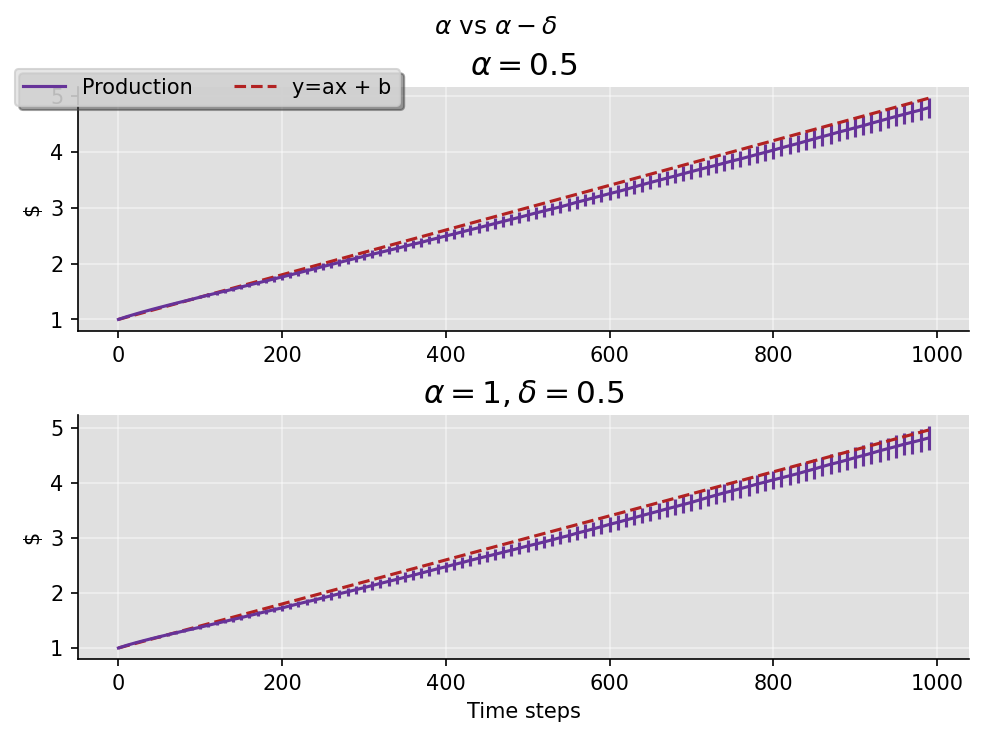

In [22]:
plot(repeats=100, N=100, steps=1000, alpha_a=0.5, alpha_ad=1, delta=0.5)

Man kunne se på fordelingen af y-værdier og sammenligne de to fordelinger

## No money investigation

In [23]:
def sim_alpha_nm(N: int, steps: int, alpha: float, r: float) -> tuple:
    """N company transactions.

    Args:
        steps (int): System iterations
        alpha (float): Money to production efficiency parameter

    Returns:
        tuple: history of p and d values for both companies
    """
    # Initial d and p values and history arrays
    p = np.ones(N)
    d = np.zeros(N)
    
    p_hist = np.ones((N, steps))
    d_hist = np.ones((N, steps))
    p_hist[:, 0] = p * 1
    d_hist[:, 0] = d * 1

    for i in range(1, steps):
        # Choose seller and buyer. Seller cannot be buyer
        buyer = np.random.randint(low=0, high=N)
        available_seller = np.arange(0, N)[np.arange(0, N) != buyer]
        seller = np.random.choice(a=available_seller)
        
        # Make transaction
        delta_d = np.min((p[buyer] - d[buyer], p[seller]))
        delta_d = np.max((0, delta_d))  # Ensure positive

        # Update p and d
        d[buyer] = d[buyer] + delta_d  # Buyer takes on debt
        d[seller] = d[seller] - delta_d  # Seller gains money i.e. loses debt
        p[buyer] = p[buyer] + alpha * delta_d  # Buyer converts money spent to production
        p[seller] = p[seller]
       
        # Pay interest every N'th step
        if i % N == 0:
            d = d + r * d  # Take on more debt to pay off interest 

        # Update values        
        d_hist[:, i] = d 
        p_hist[:, i] = p
        
    # Calculate mean values
    p_mean = np.mean(a=p_hist, axis=0)
    d_mean = np.mean(a=d_hist, axis=0)
    
    return p_mean, d_mean


def sim_alpha_delta_nm(N: int, steps: int, alpha: float, r: float, delta: float) -> tuple:
    """Two company transactions.

    Args:
        steps (int): System iterations
        alpha (float): Money to production efficiency parameter

    Returns:
        tuple: history of p and d values for both companies
    """
    # Initial d and p values and history arrays
    p = np.ones(N)
    d = np.zeros(N)
    
    p_hist = np.ones((N, steps))
    d_hist = np.ones((N, steps))
    p_hist[:, 0] = p * 1
    d_hist[:, 0] = d * 1

    for i in range(1, steps):
        # Choose seller and buyer. Seller cannot be buyer
        buyer = np.random.randint(low=0, high=N)
        available_seller = np.arange(0, N)[np.arange(0, N) != buyer]
        seller = np.random.choice(a=available_seller)
        
        # Make transaction
        delta_d = np.min((p[buyer] - d[buyer], p[seller]))
        delta_d = np.max((0, delta_d))  # Ensure positive

        # Update p and d
        d[buyer] = d[buyer] + delta_d  # Buyer takes on debt
        d[seller] = d[seller] - delta_d  # Seller gains money i.e. loses debt
        p[buyer] = p[buyer] + alpha * delta_d  # Buyer converts money spent to production
        p[seller] = p[seller] - delta * delta_d
       
        # Pay interest every N'th step
        if i % N == 0:
            d = d + r * d  # Take on more debt to pay off interest 

        # Update values        
        d_hist[:, i] = d 
        p_hist[:, i] = p
        
    # Calculate mean values
    p_mean = np.mean(a=p_hist, axis=0)
    d_mean = np.mean(a=d_hist, axis=0)
    
    return p_mean, d_mean


def alpha_mean_of_means_nm(repeats, N, steps, alpha, r):
    p_means_list = np.empty((steps, repeats))
    m_means_list = np.empty((steps, repeats))
    
    # Simulate repeats times
    for i in range(repeats):
        p_mean, m_mean = sim_alpha_nm(N, steps, alpha, r)
        p_means_list[:, i] = p_mean
        m_means_list[:, i] = m_mean
    
    # Calculate mean of means
    p_means = np.mean(p_means_list, axis=1)
    m_means = np.mean(m_means_list, axis=1)
    p_std = np.std(p_means_list, axis=1)
    m_std = np.std(m_means_list, axis=1)
    
    return p_means, m_means, p_std, m_std


def alpha_delta_mean_of_means_nm(repeats, N, steps, alpha, r, delta):
    p_means_list = np.empty((steps, repeats))
    m_means_list = np.empty((steps, repeats))
    
    # Simulate repeats times
    for i in range(repeats):
        p_mean, m_mean = sim_alpha_delta_nm(N, steps, alpha, r, delta)
        p_means_list[:, i] = p_mean
        m_means_list[:, i] = m_mean
    
    # Calculate mean of means
    p_means = np.mean(p_means_list, axis=1)
    m_means = np.mean(m_means_list, axis=1)
    p_std = np.std(p_means_list, axis=1)
    m_std = np.std(m_means_list, axis=1)
    
    return p_means, m_means, p_std, m_std

In [32]:
def plot_nm(repeats, N, steps, alpha_a, alpha_ad, r, delta, scale="log"):
    # a = alpha
    # ad = alpha delta
    # Get data
    p_a, d_a, p_std_a, d_std_a = alpha_mean_of_means_nm(repeats, N, steps, alpha_a, r)
    p_ad, d_ad, p_std_ad, d_std_ad = alpha_delta_mean_of_means_nm(repeats, N, steps, alpha_ad, r, delta)
    time = np.arange(steps)
    
    # Only include every 10'th point
    points_to_skip = 10
    p_a = p_a[::points_to_skip]
    p_ad = p_ad[::points_to_skip]
    p_std_a = p_std_a[::points_to_skip]
    p_std_ad = p_std_ad[::points_to_skip]
    time = time[::points_to_skip]
    
    # Calculate linear data
    offset_a = p_a[0]
    offset_ad = p_ad[0]
    slope_a = alpha_a / N -  offset_a / steps
    slope_ad = (alpha_ad - delta) / N - offset_ad / steps
    
    linear_a = linear(time, slope_a, b=offset_a)
    linear_ad = linear(time, slope_ad, b=offset_ad)
    
    # Create figure
    fig, ax = plt.subplots()
    
    # Alpha sim
    ax.errorbar(time, np.abs(p_a), yerr=p_std_a, label=fr"$\alpha$ = {alpha_a}")
    
    # Alpha-delta sim
    ax.errorbar(time, np.abs(p_ad), yerr=p_std_ad, label=fr"$\alpha$ = {alpha_ad:.2f}, $\delta$ = {delta}")
    
    # Axis setup
    ax.set(ylabel="$", xlabel="Time steps", yscale=scale)
    
    # Grids
    ax.grid()
    
    # Legend
    legend_elements = [Line2D([], [], color="rebeccapurple", label="Production"),]
                        # Line2D([], [], color="firebrick", label="y=ax + b", linestyle="dashed")]
    fig.subplots_adjust(hspace=0.55)
    fig.legend()
    # fig.legend(handles=legend_elements, ncols=3, bbox_to_anchor=(0.5, 0.45), loc="lower center")
    
    fig.suptitle(fr"$\alpha$ vs $\alpha - \delta$, $r={r}$")
    plt.show()

C:\Users\tobia\AppData\Local\Temp\ipykernel_8816\4107582356.py:44: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.55)


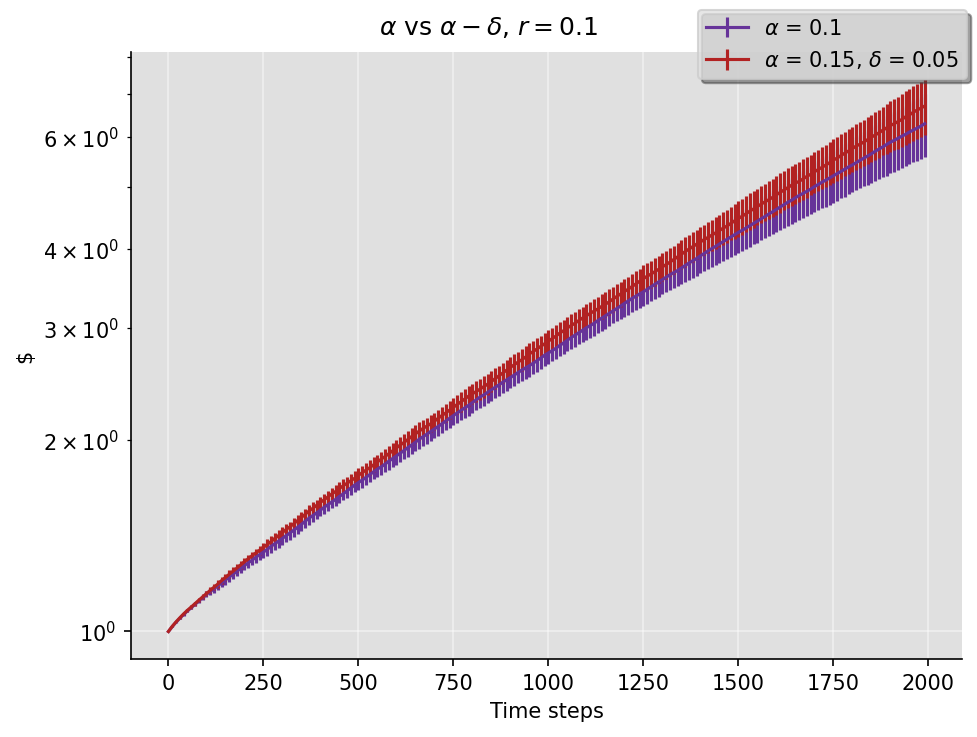

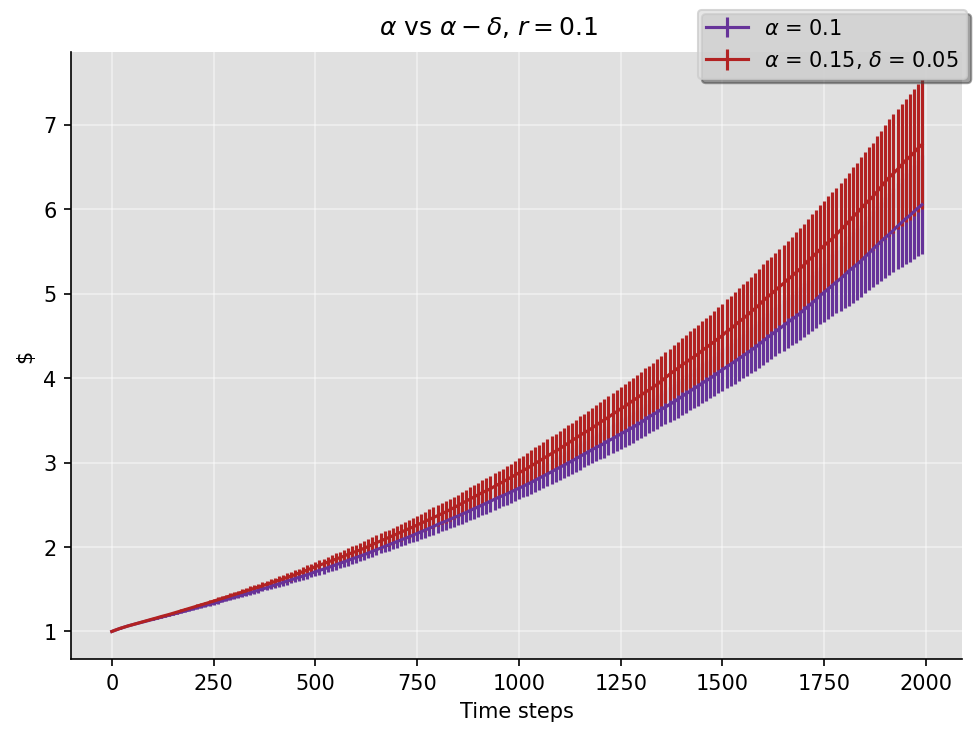

In [37]:
repeats = 20
N = 50
steps = 2000
alpha_a = 0.1
delta = 0.05
alpha_ad = alpha_a + delta
r = 0.1

plot_nm(repeats=repeats, N=N, steps=steps, alpha_a=alpha_a, alpha_ad=alpha_ad, r=r, delta=delta, scale="log")
plot_nm(repeats=repeats, N=N, steps=steps, alpha_a=alpha_a, alpha_ad=alpha_ad, r=r, delta=delta, scale="linear")

In [42]:
def plot_nm_incl_debt(repeats, N, steps, alpha_a, alpha_ad, r, delta, p_scale="log"):
    # a = alpha
    # ad = alpha delta
    # Get data
    p_a, d_a, p_std_a, d_std_a = alpha_mean_of_means_nm(repeats, N, steps, alpha_a, r)
    p_ad, d_ad, p_std_ad, d_std_ad = alpha_delta_mean_of_means_nm(repeats, N, steps, alpha_ad, r, delta)
    time = np.arange(steps)
    
    # Only include every 10'th point
    points_to_skip = 10
    p_a = p_a[::points_to_skip]
    p_ad = p_ad[::points_to_skip]
    p_std_a = p_std_a[::points_to_skip]
    p_std_ad = p_std_ad[::points_to_skip]
    d_a = d_a[::points_to_skip]
    d_ad = d_ad[::points_to_skip]
    d_std_a = d_std_a[::points_to_skip]
    d_std_ad = d_std_ad[::points_to_skip]
    time = time[::points_to_skip]
    
    # Calculate linear data
    offset_a = p_a[0]
    offset_ad = p_ad[0]
    slope_a = alpha_a / N -  offset_a / steps
    slope_ad = (alpha_ad - delta) / N - offset_ad / steps
    
    linear_a = linear(time, slope_a, b=offset_a)
    linear_ad = linear(time, slope_ad, b=offset_ad)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
    
    # Alpha sim - Production
    ax1.errorbar(time, np.abs(p_a), yerr=p_std_a, label=fr"$\alpha$ = {alpha_a}")
    ax1.errorbar(time, np.abs(p_ad), yerr=p_std_ad, label=fr"$\alpha$ = {alpha_ad}, $\delta$ = {delta}")
    ax1.set(ylabel="Production $", xlabel="Time steps", yscale=p_scale)
    ax1.grid()
    ax1.legend()
    
    # Alpha sim - Debt
    ax2.errorbar(time, np.abs(d_a), yerr=d_std_a, label=fr"$\alpha$ = {alpha_a}")
    ax2.errorbar(time, np.abs(d_ad), yerr=d_std_ad, label=fr"$\alpha$ = {alpha_ad:.2f}, $\delta$ = {delta}")
    ax2.set(ylabel="Debt $", xlabel="Time steps", yscale="linear")
    ax2.grid()
    ax2.legend()
    
    fig.subplots_adjust(hspace=0.55)
    fig.suptitle(fr"$\alpha$ vs $\alpha - \delta$, $r={r}$")
    plt.show()

C:\Users\tobia\AppData\Local\Temp\ipykernel_8816\4179463429.py:47: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.55)


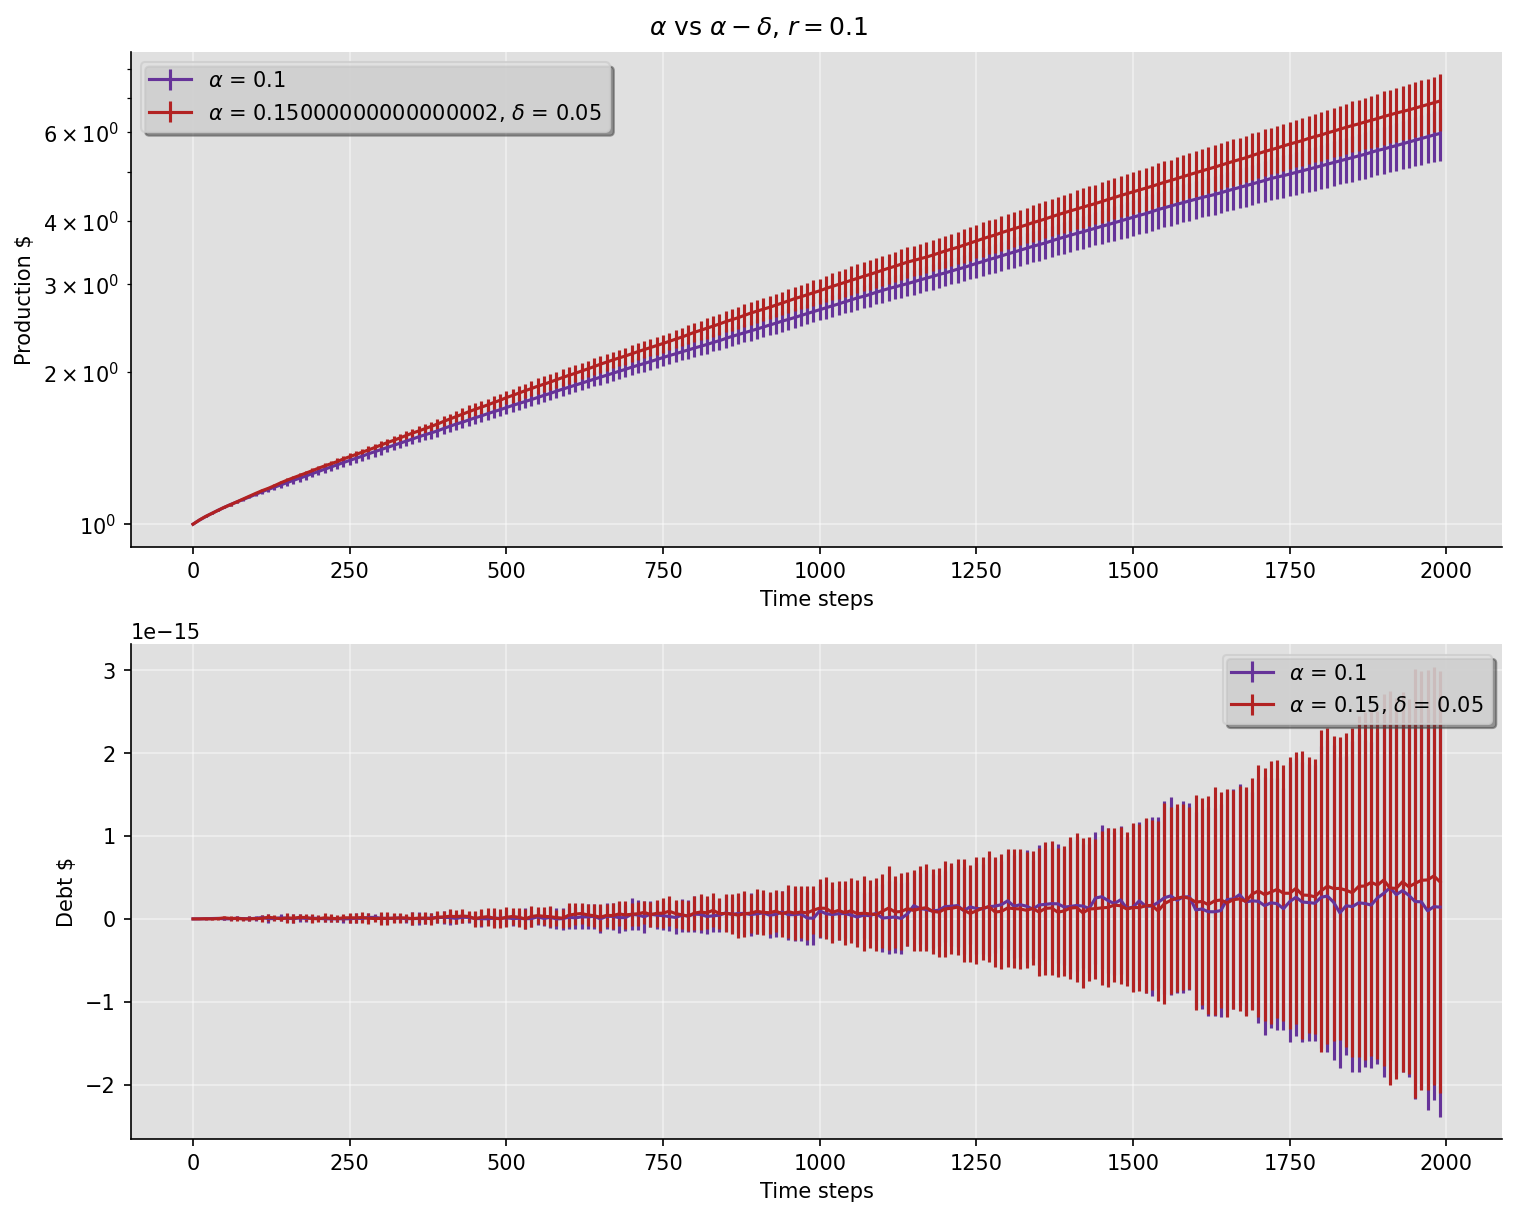

In [43]:
plot_nm_incl_debt(repeats=repeats, N=N, steps=steps, alpha_a=alpha_a, alpha_ad=alpha_ad, r=r, delta=delta, p_scale="log")

## Comparison of y data distributions

In [51]:
from scipy.stats import ks_2samp


def production_hist_comparison(repeats, N, steps, alpha, delta, r):
    alpha_ad = alpha + delta
    # Create data 
    p_means_list = np.empty((steps, repeats))
    p_ad_means_list = np.empty((steps, repeats)) 
    
    # Simulate repeats times
    for i in range(repeats):
        p_mean, _ = sim_alpha_nm(N, steps, alpha, r)
        p_mean_ad, _ = sim_alpha_delta_nm(N, steps, alpha_ad, r, delta)
        p_means_list[:, i] = p_mean
        p_ad_means_list[:, i] = p_mean_ad

    # Flatten arrays - They all come from the same distribtuiion 
    p_means_list = p_means_list.flatten()
    p_ad_means_list = p_ad_means_list.flatten()

    # Do a KS test
    ks_res = ks_2samp(data1=p_means_list, data2=p_ad_means_list)
    ks_stat = ks_res.statistic
    ks_pval = ks_res.pvalue  
    print(f"KS statistic: {ks_stat:.5f}, p-value (probability is identical): {ks_pval:.5f}")

    # Bin data
    # Number of bins using Sturges' rule
    Nbins = int(1 + np.log2(p_means_list.size))
    bins = np.linspace(1, np.max((p_means_list, p_ad_means_list)), Nbins)
    counts, edges = np.histogram(p_means_list, bins=bins)
    counts_ad, edges_ad = np.histogram(p_ad_means_list, bins=bins)
        
    # Create histograms
    fig, ax = plt.subplots()
    
    ax.stairs(counts, edges, label=fr"$\alpha={alpha}$")
    ax.stairs(counts_ad, edges_ad, label=fr"$\alpha={alpha_ad:.2f}, \delta={delta}$")
    
    ax.set(xlabel="Production $", ylabel="Frequency", title=f"Time = {steps}, Companies={100}, r={0.1}")
    ax.legend()
    ax.grid()
    plt.show() 

KS statistic: 0.09635, p-value (probability is identical): 0.00000


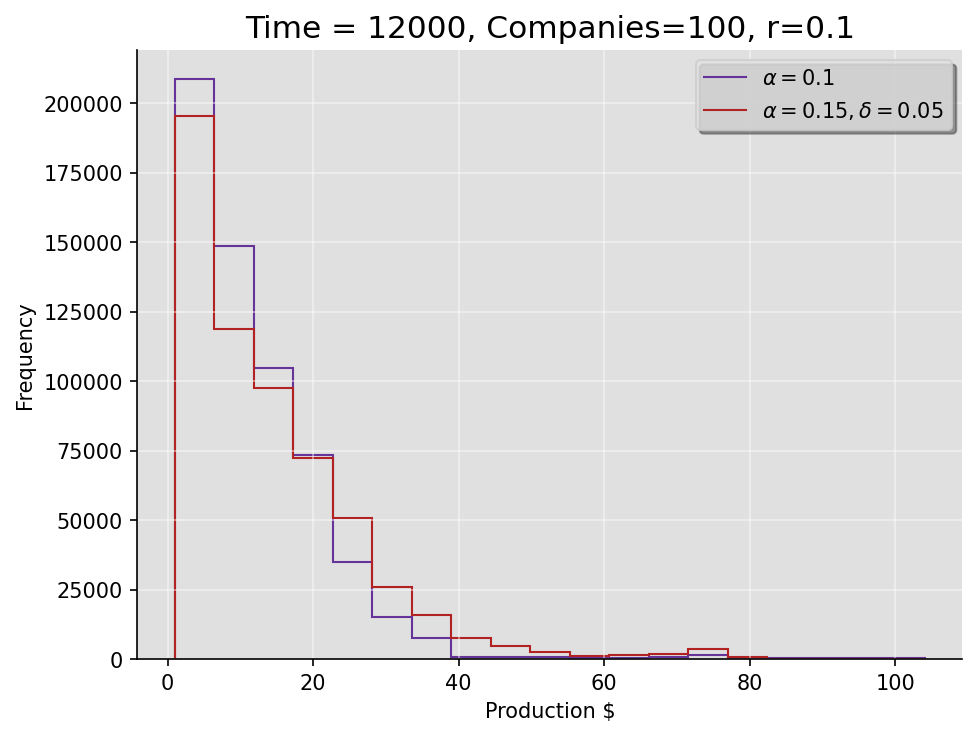

In [52]:
production_hist_comparison(repeats=50, N=100, steps=12_000, alpha=0.1, delta=0.05, r=0.1)